# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import nltk
import os

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer

import twitter

# nltk.download()

In [2]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""

ACCESS_TOKEN_KEY = ""
ACCESS_TOKEN_SECRET = ""

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [3]:
def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    def cut_url(x):
        if u'http' in x['text']:
            arr = x['text'].split(u' ')
            buf = u''
            for entry in arr:
                if entry.find(u'http') < 0:
                    buf += entry + u' '
            del x['text']
            x['text'] = buf
        if 'media' in x.keys():
            del x['media']
        return x
    
    tweets = api.GetUserTimeline(user_id, count=200, include_rts=False, exclude_replies=True)
    tweets = list(map(lambda x: x.AsDict(), tweets))
    tweets = list(map(lambda x: cut_url(x), tweets))
    return tweets

In [4]:
tweets = get_user_tweets(202388889)

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [5]:
import re
def get_words(text):
    """returns list of words"""
    return filter(lambda x: x if (len(x) > 0) else None, re.sub('[!@#$,.%^&*\n\\\t()\[\];:]', ' ', text).split(' '))

In [6]:
print get_words("Here \tare, [#different(] words)\n!")

['Here', 'are', 'different', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [7]:
def get_tokens(words):
    """returns list of tokens"""
    wnl = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    result = []
    for word in words:
        if not word in stop:
            result.append(word)
    result = map(lambda x: wnl.lemmatize(x.lower()), result)
    return result

In [8]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [9]:
def get_tweet_tokens(tweet):
    txt = tweet['text']
    return filter(lambda x: x if (len(x) > 0) else None, get_tokens(get_words(txt)))

In [10]:
for i in range(10):
    print tweets[i]['text']
    print get_tweet_tokens(tweets[i])
    print

Sunset FL style 
[u'sunset', u'fl', u'style']

Pinellas Park Art Walk 
[u'pinellas', u'park', u'art', u'walk']

Woot! No work today after all. Boss called in sick. So I'm chilling at home.
[u'woot', u'no', u'work', u'today', u'bos', u'called', u'sick', u'so', u"i'm", u'chilling', u'home']

Cheering myself up because I have to go to work later. Mmmm Bucky Barnes.... 
[u'cheering', u'i', u'go', u'work', u'later', u'mmmm', u'bucky', u'barnes']

Saturday and I will be working. Ugh. 
[u'saturday', u'i', u'working', u'ugh']

RT @BuzzFeedNews: Two Sex Shop Employees Chased Off An Armed Robber By Throwing Dildos At Him 
[u'rt', u'buzzfeednews', u'two', u'sex', u'shop', u'employee', u'chased', u'off', u'an', u'armed', u'robber', u'by', u'throwing', u'dildo', u'at', u'him']

Really digging the new @LeahRemini show about Scientology. I heard her on @DonGeronimoShow. Now I'm hooked! Go Leah!!!
[u'really', u'digging', u'new', u'leahremini', u'show', u'scientology', u'i', u'heard', u'dongeronimoshow

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [11]:
processed_users = set()
user_features = [[],[]]

In [12]:
tmp_file_name = 'tmp_features'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name, 'r') as f:
        for line in f:
            try:
                ufeature = json.loads(line)
                if not ufeature['uid'] in processed_users:
                    user_features[0].append(ufeature['uid'])
                    user_features[1].append(ufeature['features'])
                    processed_users.add(ufeature['uid'])
                #print 'Lucky'
            except:
                #print 'No luck'
                ;

In [13]:
len(user_features[0])

11463

In [14]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    # save intermediate result
    f = open('dump', 'w')
    uid_list = df_users['uid'].tolist()
    i = 0
    for uid in uid_list:
        if i % 10 == 0:
            print i
        i += 1
        if not uid in processed_users:
            tokens = []
            try:
                tweets = get_user_tweets(uid)
                for tweet in tweets:
                    tokens.append(get_tweet_tokens(tweet))
                tokens = [item for sublist in tokens for item in sublist] 
                dct = dict.fromkeys(tokens, 0.0)
                for token in tokens:
                    dct[token] += 1.0
                for token in tokens:
                    dct[token] /= len(tokens)
                result = {'uid' : uid,
                          'features' : dct}
                f.write(json.dumps(result))
                f.write('\n')
                user_features[0].append(uid)
                user_features[1].append(dct)
                processed_users.add(uid)
            except:
                print 'Smth wrong', i
        else:
            continue
    
    return user_features[0], user_features[1]

In [15]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test_submition.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

In [16]:
users, users_tokens = collect_users_tokens(df_users)

0
Smth wrong 4
Smth wrong 5
10
20
30
40
50
60
Smth wrong 65
70
80
90
Smth wrong 98
100
110
120
Smth wrong 121
Smth wrong 130
130
Smth wrong 133
140
150
Smth wrong 152
160
Smth wrong 168
170
180
190
200
210
220
230
240
250
260
Smth wrong 265
270
280
Smth wrong 286
290
300
Smth wrong 303
310
320
330
340
350
360
370
380
390
400
410
Smth wrong 415
420
Smth wrong 424
430
440
450
Smth wrong 454
460
Smth wrong 462
Smth wrong 466
470
Smth wrong 479
480
490
500
Smth wrong 507
Smth wrong 508
510
520
530
540
Smth wrong 545
550
560
570
580
590
600
Smth wrong 608
610
Smth wrong 612
620
630
Smth wrong 633
640
Smth wrong 641
650
660
670
680
690
700
710
Smth wrong 719
720
730
Smth wrong 735
740
750
760
770
780
Smth wrong 785
790
Smth wrong 798
800
Smth wrong 808
Smth wrong 809
810
820
830
840
850
860
870
880
890
900
910
920
Smth wrong 927
Smth wrong 929
930
940
950
Smth wrong 952
960
970
980
Smth wrong 989
990
Smth wrong 999
Smth wrong 1000
1000
1010
Smth wrong 1018
1020
1030
1040
1050
Smth wrong 1060

In [17]:
print 'Done'

Done


In [18]:
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [20]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [26]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [44]:
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    txt = ' '.join(v.get_feature_names())
    wc = WordCloud().generate(txt)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    return

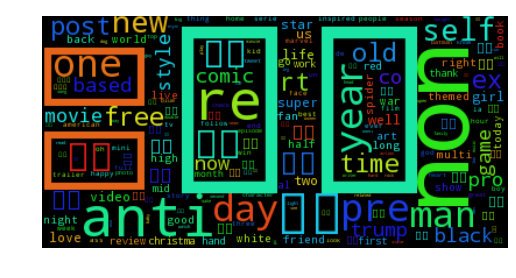

In [45]:
draw_tag_cloud(v, vs)